In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

# 加载 MNIST 数据集
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

# 选择类别 3, 8, 9
selected_classes = [3, 8, 9]
mask = np.isin(y, selected_classes) 
print(mask)
X_selected = X[mask] # 二维数组, shape = (num_samples(tot number of 3, 8, 9), num_features(29*29 pixels and flatten to 784 D))
y_selected = y[mask] # 一维数组, shape = (num_samples,) tags of each sample

#print(X_selected)
print(y_selected)
print(X_selected.shape) # (21658, 784)
print(y_selected.shape) # (21658,)
# rank is 2

[False False False ... False False False]
4        9
7        3
10       3
12       3
17       8
        ..
69975    3
69986    3
69991    8
69992    9
69996    3
Name: class, Length: 20924, dtype: int64
(20924, 784)
(20924,)


In [ ]:
# 计算全局均值
overall_mean = np.mean(X_selected, axis=0)  # 一维数组, shape = (num_features,)
print(f"Overall mean: {overall_mean[200:300]}")
# print(f"Overall mean shape: {overall_mean.shape}")

# 初始化 S_w 和 S_b
S_w = np.zeros((X_selected.shape[1], X_selected.shape[1]))
S_b = np.zeros((X_selected.shape[1], X_selected.shape[1]))
print(f"S_w shape: {S_w.shape}")

# 遍历每个类别
for cls in selected_classes:
    # S_w = \sum_{i=1}^{N_c} (x_i - mean_c) (x_i - mean_c)^T
    X_cls = X_selected[y_selected == cls]
    print(f"Class {cls} shape: {X_cls.shape}")
    cls_mean = np.mean(X_cls, axis=0)
    print(f"Class {cls} mean: {cls_mean[200:201]}")
    
    # 类内散度
    S_w += (X_cls - cls_mean).T @ (X_cls - cls_mean)
    
    # 类间散度
    # S_b = N_c (mean_c - mean) (mean_c - mean
    n_cls = X_cls.shape[0]
    print(f"Number of samples in class {cls}: {n_cls}")
    # mean_diff = cls_mean - overall_mean
    mean_diff = (cls_mean.to_numpy() - overall_mean.to_numpy()).reshape(-1, 1)

    S_b += n_cls * (mean_diff @ mean_diff.T)

rank = np.linalg.matrix_rank(S_w)
print(f"Rank of S_w: {rank}")

Overall mean: pixel201      3.577089
pixel202      8.095249
pixel203     15.947524
pixel204     28.065284
pixel205     45.355381
               ...    
pixel296     82.809023
pixel297    109.688922
pixel298    132.815236
pixel299    135.522701
pixel300    113.386159
Length: 100, dtype: float64
S_w shape: (784, 784)
Class 3 shape: (7141, 784)
Class 3 mean: pixel201    9.950287
dtype: float64
Number of samples in class 3: 7141
Class 8 shape: (6825, 784)
Class 8 mean: pixel201    0.528938
dtype: float64
Number of samples in class 8: 6825
Class 9 shape: (6958, 784)
Class 9 mean: pixel201    0.026157
dtype: float64
Number of samples in class 9: 6958
Rank of S_w: 637


In [56]:
# 解决广义特征值问题

epsilon = 1e-6
S_w += epsilon * np.eye(S_w.shape[0])

# S_b w = \lambda S_w w  general eigenvalue problem of S_w^{-1} S_b
eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_w) @ S_b)

# 按特征值排序
sorted_indices = np.argsort(-eigvals)
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# 选择前两个最大特征值对应的特征向量
W = eigvecs[:, :2]

In [60]:
# 数据投影到二维空间
X_projected = X_selected @ W
print(f"Projected data shape: {X_projected.shape}")
print(type(X_projected))

Projected data shape: (20924, 2)
<class 'pandas.core.frame.DataFrame'>


<class 'numpy.ndarray'>
Class: 3
y_selected == cls: 7141 samples match.
Class: 8
y_selected == cls: 6825 samples match.
Class: 9
y_selected == cls: 6958 samples match.


/opt/miniconda3/envs/cmsc/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/cmsc/lib/python3.13/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


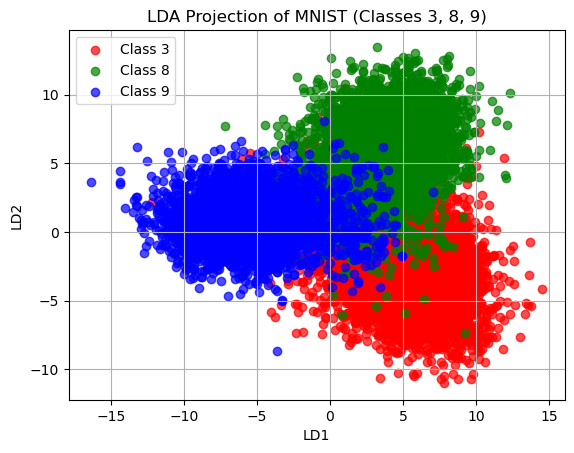

In [61]:
X_projected = X_projected if isinstance(X_projected, np.ndarray) else X_projected.to_numpy()
print(type(X_projected))
for i, cls in enumerate(selected_classes):
    cls = int(cls)  # 确保 cls 是整数
    print(f"Class: {cls}")
    print(f"y_selected == cls: {np.sum(y_selected == cls)} samples match.")
    
    plt.scatter(
        X_projected[y_selected == cls, 0], 
        X_projected[y_selected == cls, 1], 
        label=f"Class {cls}", alpha=0.7, color=colors[i]
    )

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Projection of MNIST (Classes 3, 8, 9)")
plt.legend()
plt.grid()
plt.show()


In [63]:
# 计算全局均值向量
mean_vector = np.mean(X_selected, axis=0)

# 数据中心化
X_centered = X_selected - mean_vector


# 计算 SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# 提取前两个主成分
V2 = Vt[:2, :]  # 前两行是前两个右奇异向量
